In [1]:
import math

from matplotlib import pyplot as plt
import pandas as pd
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')

/tmp/ipykernel_82785/521824840.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("../data/summary/all/metrics.csv", index_col=0)

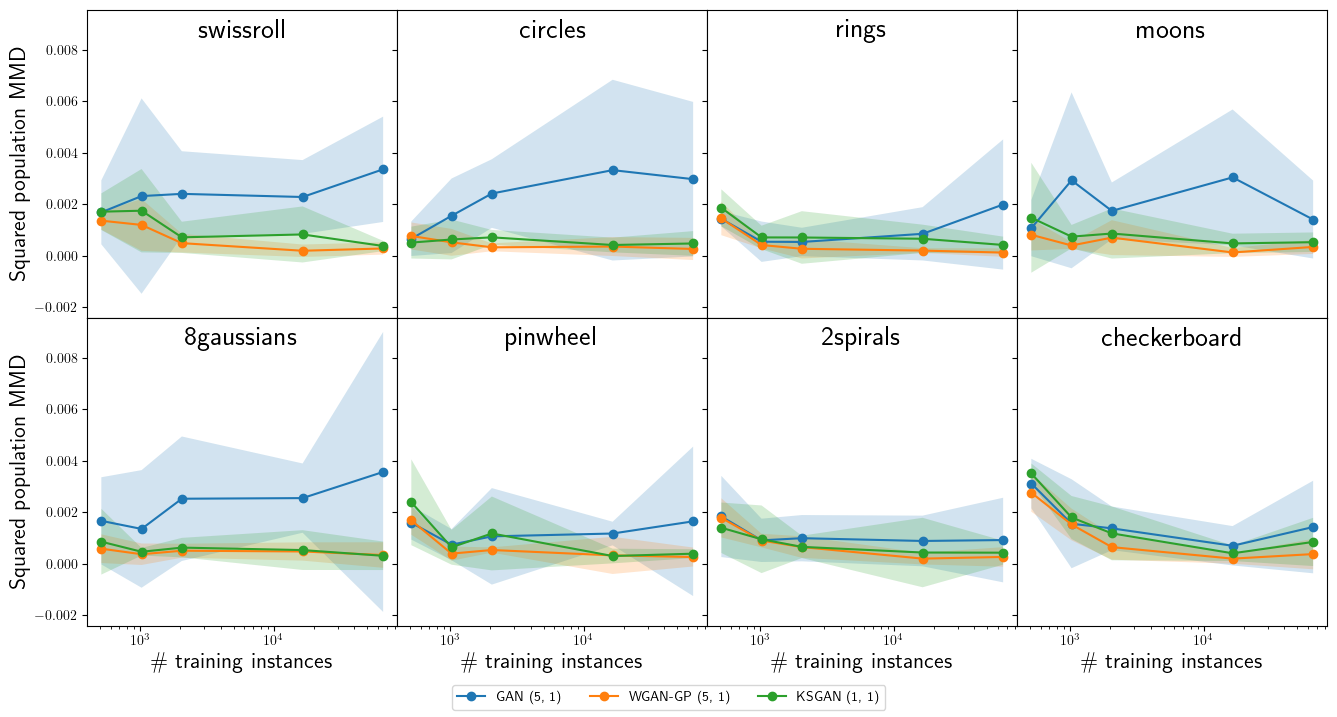

In [3]:
def plot_data(df):
    """Plots mmd vs sb for each dataset and model in a dataframe.

    Args:
        df (pandas.DataFrame): The dataframe containing the data.
    """

    datasets = df["dataset"].unique()
    datasets = [d for d in datasets if d not in ("line", "cos", "gaussian")]
    models = df["model"].unique()
    models = [m for m in models if m not in ("nf",)]
    model_display_dict = dict(zip(models, [r"GAN (5, 1)", r"WGAN-GP (5, 1)", r"KSGAN (1, 1)"]))
    fig, axs = plt.subplots(
        nrows=(nrows:=int(math.sqrt(len(datasets)))),
        ncols=(ncols:=len(datasets) // nrows + int(len(datasets) % nrows > 0)),
        figsize=(4*ncols, 4*nrows),
        sharex=True, sharey=True,
    )
    axs_org = axs
    axs = axs.ravel()
    for dataset_idx, dataset in enumerate(datasets):
        df_filtered = df[df["dataset"] == dataset]
        for model in models:
            if model in ("nf"):
                continue
            df_model = df_filtered[df_filtered["model"] == model]
            df_avg = df_model.groupby("sb").agg(mean_mmd=("mmd", "mean"), std_mmd=("mmd", "std"))
            mean_mmd, std_mmd = df_avg["mean_mmd"], df_avg["std_mmd"]
            lower, upper = mean_mmd - 2*std_mmd, mean_mmd + 2*std_mmd
            axs[dataset_idx].plot(
            df_avg.index, mean_mmd, label=model_display_dict[model], marker="o", linestyle="-"
            )
            axs[dataset_idx].fill_between(
                df_avg.index, lower, upper, alpha=0.2,
            )
            axs[dataset_idx].set_title(f"{dataset}", y=1.0, pad=-20, fontsize=20)
            if axs[dataset_idx] in axs_org[:,0].tolist():
                axs[dataset_idx].set_ylabel("Squared population MMD", fontsize=16)
            if axs[dataset_idx] in axs_org[-1].tolist():
                axs[dataset_idx].set_xlabel("\# training instances", fontsize=16)
            axs[dataset_idx].set_xscale('log')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(models))
    fig.subplots_adjust(wspace=0., hspace=0)
    plt.savefig("metrics_grid.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
    plt.show()

plot_data(df.copy())


In [4]:
PATH_TO_KSGAN_K5 = "./metrics-ksgan-k-5.csv"

In [5]:
df_ksgan_k5 = pd.read_csv(PATH_TO_KSGAN_K5, index_col=0)
df_ksgan_k5["model"] = df_ksgan_k5["model"].apply(lambda x: f"{x}-k5")
df = pd.concat((df, df_ksgan_k5))

In [9]:
def df_to_latex_table(df):
    df["mmd"] = df["mmd"]*(10**3)
    df = df[(df['sb'] == 65536)]
    df = df[(df['dataset'] != "gaussian") & (df['dataset'] != "line") & (df['dataset'] != "cos")]
    df = df[(df['model'] != "nf")]
    df = df[['dataset', 'model', 'mmd']]
    df_grouped = df.groupby(by=['dataset', "model"]).agg(lambda x: f"{x.mean():.2f} ({x.std():.3f})").unstack(level=-1)
    df_grouped.columns = df_grouped.columns.droplevel()
    df_grouped = df_grouped[["gan", "wgan", "ksgan",]]
    
    return df_grouped.loc[["swissroll", "circles", "rings", "moons", "8gaussians", "pinwheel", "2spirals", "checkerboard"]].to_latex()

latex_code = df_to_latex_table(df.copy())
print(latex_code)


\begin{tabular}{llll}
\toprule
model & gan & wgan & ksgan \\
dataset &  &  &  \\
\midrule
swissroll & 3.37 (1.023) & 0.29 (0.119) & 0.39 (0.100) \\
circles & 2.98 (1.501) & 0.27 (0.215) & 0.49 (0.240) \\
rings & 2.00 (1.264) & 0.13 (0.082) & 0.43 (0.162) \\
moons & 1.41 (0.757) & 0.35 (0.136) & 0.53 (0.189) \\
8gaussians & 3.57 (2.719) & 0.35 (0.248) & 0.32 (0.277) \\
pinwheel & 1.66 (1.451) & 0.27 (0.184) & 0.40 (0.086) \\
2spirals & 0.93 (0.822) & 0.27 (0.191) & 0.44 (0.232) \\
checkerboard & 1.43 (0.899) & 0.38 (0.296) & 0.86 (0.468) \\
\bottomrule
\end{tabular}

